<a href="https://colab.research.google.com/github/praveen-raj-m/satellite-imagery-classification/blob/main/EUROSAT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project title:**
#**Land-Cover Classification using EuroSAT Dataset**

Based on a paper published in 2019, we worked on this data to classify the land-cover class of remote sensing images using deep learning techniques. 

About the data:

This dataset contains over 27000 images spread through 10 classes, which were collected by the Sentinel-2A satellite in 64x64 format. We will be working with only RGB out of 13 spectral bands of these hyperspectral images.


In [ ]:
# Importing few libraries
import os
import shutil
import random
from tqdm import tqdm
import cv2
import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

**Unzipping data from the drive and loading them.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip '/content/drive/MyDrive/archive.zip'

Streaming output truncated to the last 5000 lines.
  inflating: 2750/River/River_1449.jpg  
  inflating: 2750/River/River_145.jpg  
  inflating: 2750/River/River_1450.jpg  
  inflating: 2750/River/River_1451.jpg  
  inflating: 2750/River/River_1452.jpg  
  inflating: 2750/River/River_1453.jpg  
  inflating: 2750/River/River_1454.jpg  
  inflating: 2750/River/River_1455.jpg  
  inflating: 2750/River/River_1456.jpg  
  inflating: 2750/River/River_1457.jpg  
  inflating: 2750/River/River_1458.jpg  
  inflating: 2750/River/River_1459.jpg  
  inflating: 2750/River/River_146.jpg  
  inflating: 2750/River/River_1460.jpg  
  inflating: 2750/River/River_1461.jpg  
  inflating: 2750/River/River_1462.jpg  
  inflating: 2750/River/River_1463.jpg  
  inflating: 2750/River/River_1464.jpg  
  inflating: 2750/River/River_1465.jpg  
  inflating: 2750/River/River_1466.jpg  
  inflating: 2750/River/River_1467.jpg  
  inflating: 2750/River/River_1468.jpg  
  inflating: 2750/River/River_1469.jpg  
  inflat

**DATA PRE PROCESSING**

we have all images to our working folder. lets visualize the data using plots.


In [ ]:
DATASET = "/content/2750" #path to the folder containg all the images

LABELS = os.listdir(DATASET) #class names
print(LABELS)

['River', 'Pasture', 'Industrial', 'AnnualCrop', 'SeaLake', 'Forest', 'Residential', 'PermanentCrop', 'Highway', 'HerbaceousVegetation']


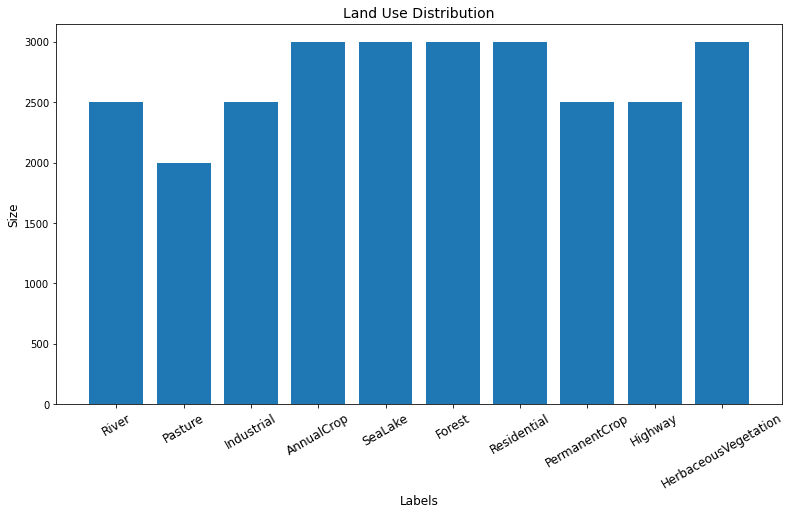

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))

    
plt.figure(figsize=(13, 7))
plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=30)
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Size', fontsize=12)
plt.title('Land Use Distribution', fontsize=14);

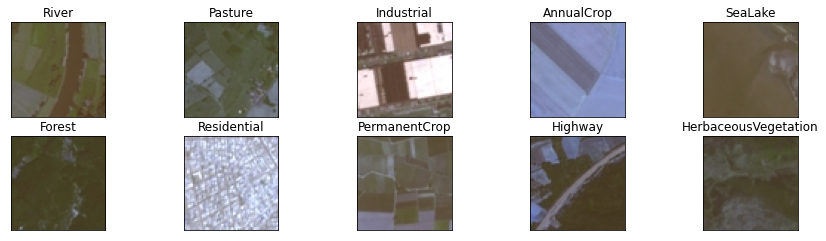

In [ ]:
 #plotting an image from all the labels using paths of the image
paths = [os.path.join(DATASET, l, l+'_500.jpg') for l in LABELS]
plt.figure(figsize=(15, 8))
for i in range(10):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img=cv2.imread(paths[i])
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])



In [ ]:
#splitting the data for traing and testing using 'stratified shufflesplit' and 'image data generator'.
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = '/content/training'
TEST_DIR = '/content/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [ ]:
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(DATASET+'/'+l):
       data.update({os.path.join(DATASET, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)

# split the list of image paths
for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/content/2750', '/content/training', i) for i in train_paths]
    new_test_paths = [re.sub('/content/2750', '/content/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    # move the files
    print("moving training files..")
    for i in tqdm(train_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  4%|▎         | 788/21600 [00:00<00:02, 7869.78it/s]

moving training files..


 15%|█▍        | 801/5400 [00:00<00:00, 8001.92it/s]

moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 7593.62it/s]


In [ ]:
# Create a ImageDataGenerator Instance which can be used for data augmentation

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True
#   validation_split=0.2
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    #subset='training',
    color_mode='rgb',
    shuffle=True,
    seed=69
)


# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
#class indicies to identify each class
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [ ]:
np.save('class_indices', train_generator.class_indices)

#**MODEL BUILDING**

In [ ]:
#importing all required libraries
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.applications import ResNet50V2
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [ ]:
#setting up GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [ ]:
# function for setting up of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    

  conv_base = ResNet50V2(include_top=False,
                      weights='imagenet', 
                      input_shape=input_shape)

  top_model = conv_base.output
  top_model = Flatten()(top_model)
  top_model = Dense(2048, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
    
  output_layer = Dense(n_classes, activation='softmax')(top_model)
    
  model = Model(inputs=conv_base.input, outputs=output_layer)
        
  if type(fine_tune) == int:
      for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
  else:
       for layer in conv_base.layers:
            layer.trainable = False

  model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
  return model
# function for plotting model history
def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();
# function for results and metrics
def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat
#function for plotting predictions
def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))    

In [ ]:
#creating the model
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
resnet50V2_model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_____________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')


In [ ]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
337/337 [==============================] - 79s 133ms/step - loss: 4.8728 - categorical_accuracy: 0.5786 - val_loss: 0.9213 - val_categorical_accuracy: 0.7470

Epoch 00001: val_categorical_accuracy improved from -inf to 0.74702, saving model to ../working/model.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 43s 126ms/step - loss: 1.0873 - categorical_accuracy: 0.6844 - val_loss: 1.0361 - val_categorical_accuracy: 0.7571

Epoch 00002: val_categorical_accuracy improved from 0.74702 to 0.75707, saving model to ../working/model.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 42s 125ms/step - loss: 1.0980 - categorical_accuracy: 0.7051 - val_loss: 0.8769 - val_categorical_accuracy: 0.7310

Epoch 00003: val_categorical_accuracy did not improve from 0.75707
Epoch 4/50
337/337 [==============================] - 43s 128ms/step - loss: 1.0451 - categorical_accuracy: 0.7057 - val_loss: 0.8065 - val_categorical_accuracy: 0.7667

Epoch 0000

In [ ]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
337/337 [==============================] - 54s 141ms/step - loss: 2.5239 - categorical_accuracy: 0.5036 - val_loss: 0.9551 - val_categorical_accuracy: 0.7587

Epoch 00001: val_categorical_accuracy did not improve from 0.82254
Epoch 2/100
337/337 [==============================] - 46s 138ms/step - loss: 0.8585 - categorical_accuracy: 0.7493 - val_loss: 0.5223 - val_categorical_accuracy: 0.8592

Epoch 00002: val_categorical_accuracy improved from 0.82254 to 0.85919, saving model to ../working/model.weights.best.hdf5
Epoch 3/100
337/337 [==============================] - 47s 138ms/step - loss: 0.6570 - categorical_accuracy: 0.8006 - val_loss: 0.4084 - val_categorical_accuracy: 0.8890

Epoch 00003: val_categorical_accuracy improved from 0.85919 to 0.88895, saving model to ../working/model.weights.best.hdf5
Epoch 4/100
337/337 [==============================] - 47s 140ms/step - loss: 0.5369 - categorical_accuracy: 0.8382 - val_loss: 0.4126 - val_categorical_accuracy: 0.8852

Epo

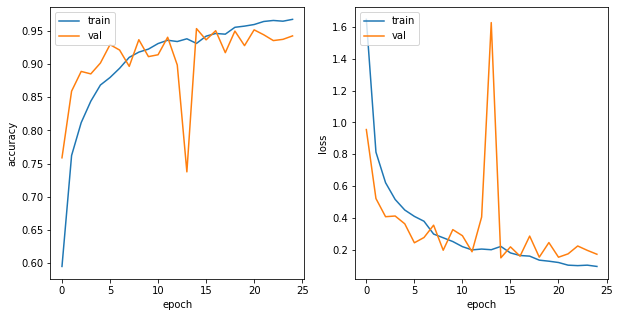

In [ ]:
#plotting the model history
plot_history(resnet50V2_history)

In [ ]:
#finding scores of the metrics defined
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.9496296296296296
Global F2 Score: 0.9496296296296296


,Precision,Recall,F-Score,Support
AnnualCrop,0.879154,0.970000,0.922345,600.0
Forest,0.989831,0.973333,0.981513,600.0
HerbaceousVegetation,0.957192,0.931667,0.944257,600.0
Highway,0.946667,0.852000,0.896842,500.0
Industrial,0.954724,0.970000,0.962302,500.0
Pasture,0.937811,0.942500,0.940150,400.0
PermanentCrop,0.917864,0.894000,0.905775,500.0
Residential,0.967690,0.998333,0.982773,600.0
River,0.957746,0.952000,0.954865,500.0
SeaLake,0.986689,0.988333,0.987510,600.0


From the results we can see that using RESNET50V2 WE GOT

**Accuracy: 0.9496296296296296**

**Global F2 Score: 0.9496296296296296**